# Segmenting and Clustering Neighborhoods in Toronto

Import necessary libraries

In [1]:
import numpy as np
import pandas as pd

from urllib.request import urlopen
from bs4 import BeautifulSoup

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

## Section 1: scrap Canada Postal Codes from Wikipedia

#### Get the HTML content of the given URL

In [2]:
def getHTMLContent(link):
    html = urlopen(link)
    soup = BeautifulSoup(html, 'html.parser')
    return soup

#### Get the raw table and transform it into a _Pandas_ DataFrame:
1. First select the HTML _table_ having the class _wikitable sortable_
1. Transform the HTML into a list or _rows_, based on the markup _tr_
1. For each _row_, get the content of the markup _td_

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
content = getHTMLContent(url)

table_html = content.find('table', {'class': 'wikitable sortable'})
rows = table_html.find_all('tr')

table = [['PostalCode', 'Borough', 'Neighborhood']]

for row in rows[1:]:
    cells = [cell.get_text().strip() for cell in row.find_all('td')]
    table.append(cells)
    
df = pd.DataFrame(columns=table[0], data=table[1:])
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Replace "Not assigned" values by np.NaN

In [4]:
df.replace("Not assigned", np.nan, inplace=True)

print("Shape before dropping NaN: {}".format(df.shape))

df.dropna(subset=["Borough"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Shape after dropping NaN: {}".format(df.shape))

Shape before dropping NaN: (288, 3)
Shape after dropping NaN: (211, 3)


In [5]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


#### Default the value of the Neighborhood by the one from the Borough when NaN

In [6]:
print("Value before filling NA: {}".format(df.iloc[6,2]))
df["Neighborhood"] = df["Neighborhood"].fillna(df["Borough"])
print("Value after filling NA: {}".format(df.iloc[6,2]))

Value before filling NA: nan
Value after filling NA: Queen's Park


#### Group the table by Postal Code (to have only one entry by Postal Code)
First check we have  several rows for some Postal Codes

In [7]:
df[df["PostalCode"]=="M5A"]

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park


Group by _PostalCode_ and apply an "aggregate" function.  
Then remove duplicates  
Check the result

In [8]:
df["Neighborhood"] = df.groupby(["PostalCode", "Borough"])["Neighborhood"].transform(lambda x: ", ".join(x))
df.drop_duplicates(inplace=True)
df[df["PostalCode"]=="M5A"]

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"


In [9]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
4,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,M7A,Queen's Park,Queen's Park


In [10]:
df.shape

(103, 3)

This is the end of the scraping section

## Section 2: Retrieve Boroughs coordinates (latitude and longitude)

#### Get the file containing the coordinates as the call to the google API was not working

In [11]:
!wget -q -O 'toronto.csv' https://cocl.us/Geospatial_data

In [12]:
neighborhood_coordinates = pd.read_csv('toronto.csv')
neighborhood_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Map this file to the Borough DataFrame

In [13]:
df = df.join(neighborhood_coordinates.set_index('Postal Code'), on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
4,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
6,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


This is the end of the section 2

## Section 3: explore data

Define a draw_map fonction in order to dislay on a map:  
- markers at the given coordinates
- with colors corresponding to their cluster label (if given, else blue)
- labels to be displayed when the marker is selected

In [3]:
def draw_map(data, latitude='Latitude', longitude='Longitude', cluster=None, labels=None, separator=", ", zoom=11):
    my_map = folium.Map(location=[(data[latitude].max() + data[latitude].min())/2, (data[longitude].max() + data[longitude].min())/2], zoom_start=zoom)

    #define colors if cluster labels are provided
    if not cluster is None:
        cluster_labels = data[data[cluster].notna()][cluster].unique()
        nb_clusters = len(cluster_labels)

        # set color scheme for the clusters
        x = np.arange(nb_clusters)
        ys = [i + x + (i*x)**2 for i in range(nb_clusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]
    
    # add markers to map
    for index, row in data.iterrows():
        #define the label. Cluster labels are displayed when they are provided
        if not labels is None:
            label = separator.join([row[lab] for lab in labels])
            if not cluster is None:
                label = label + separator + "Cluster: {}".format(row[cluster])
            label = folium.Popup(label, parse_html=True)
        else:
            label = None
        
        #Color of the marker
        if not cluster is None:
            if np.isnan(row[cluster]):
                #black if cluster labels are provided but the marker is an outlier
                color = "#000000"
            else:
                color = rainbow[int(row[cluster])-1]
        else:
            #blue by default
            color = 'blue'
        folium.CircleMarker(
            [row[latitude], row[longitude]],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            parse_html=False).add_to(my_map)  
    return my_map

#### Draw the map, first without clusters

In [15]:
draw_map(df, labels=["PostalCode", "Borough", "Neighborhood"], separator=' | ')

Foursquare credentials

In [16]:
CLIENT_ID = 'TYGHAZBMSVFHL2RBYWVEZ11O32I3ETEZHK3S42XMUVE3NBK1' # your Foursquare ID
CLIENT_SECRET = 'XH25F03PXPOB4AP0VIIALPJ5MP43PBLZMLP414YLH2BJAIGU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TYGHAZBMSVFHL2RBYWVEZ11O32I3ETEZHK3S42XMUVE3NBK1
CLIENT_SECRET:XH25F03PXPOB4AP0VIIALPJ5MP43PBLZMLP414YLH2BJAIGU


In [17]:
LIMIT = 100
radius = 500

To get Venues close to the given coordinates

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, end=" ")
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get all the venues close to the given Borough

In [19]:
toronto_venues = getNearbyVenues(names=df['PostalCode'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

M3A M4A M5A M6A M7A M9A M1B M3B M4B M5B M6B M9B M1C M3C M4C M5C M6C M9C M1E M4E M5E M6E M1G M4G M5G M6G M1H M2H M3H M4H M5H M6H M1J M2J M3J M4J M5J M6J M1K M2K M3K M4K M5K M6K M1L M2L M3L M4L M5L M6L M9L M1M M2M M3M M4M M5M M6M M9M M1N M2N M3N M4N M5N M6N M9N M1P M2P M4P M5P M6P M9P M1R M2R M4R M5R M6R M7R M9R M1S M4S M5S M6S M1T M4T M5T M1V M4V M5V M8V M9V M1W M4W M5W M8W M9W M1X M4X M5X M8X M4Y M7Y M8Y M8Z 

In [24]:
toronto_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M3A,43.753259,-79.329656,TTC stop - 44 Valley Woods,43.755402,-79.333741,Bus Stop
3,M4A,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,M4A,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


#### Compute the profile of each Borough
The profile is given by the proportion of each Venue Type in the given radius (500m) from the Borough center

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped.head()

,PostalCode,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Draw the Elbow to find the optimal k to use for K-means

In [28]:
def draw_elbow(features, k_max=10):
    plt.plot()

    distortions = []
    K = range(1, k_max)
    for k in K:
        print("{}...".format(k), end="")
        kmeanModel = KMeans(n_clusters=k).fit(features)
        distortions.append(sum(np.min(cdist(features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / features.shape[0])

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...

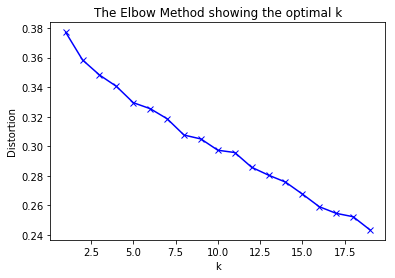

In [30]:
toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)
draw_elbow(toronto_grouped_clustering, 20)

We will use k=8

In [31]:
# run k-means clustering
kmeans = KMeans(n_clusters=8, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 6],
      dtype=int32)

#### Add the cluster labels to the initial Borough DataFrame

In [32]:
# add clustering labels
toronto_grouped.insert(1, 'Cluster Labels', kmeans.labels_)

df_labelled = df.copy()
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_labelled = df_labelled.join(toronto_grouped[["PostalCode", "Cluster Labels"]].set_index('PostalCode'), on='PostalCode')

df_labelled.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,5.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1.0
4,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1.0
6,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,1.0


#### Display the map with the cluster labels

In [33]:
draw_map(df_labelled, labels=["PostalCode", "Borough", "Neighborhood"], cluster="Cluster Labels", separator=' | ')